# Massachusetts Bay Transportation Authority (MBTA)  Transit API Project

**Mauricio Ferragut**

[Back to top](#Index)

## Abstract

This project aims to connect to the MBTA API and collect real time data on bus location for buses on Route 1, as well as implement change data capture across different databases and subsequently perform analysis and visualization of the data. To accomplish this, I wrote a Flask server in Python which connects to the MBTA API and collects data every ten seconds, storing it in a dictionary. I also created a Docker network connecting containers of a SQL database, a Mongo database, and Debezium. Once the data is stored in a dictionary, it is then inserted into the mySQL database container using a Python script, and Debezium performs change data capture anytime there is new data entered into the SQL database, storing it once again in the MongoDB container. Finally, some data analysis and visualization was performed on the transit data.

[Back to top](#Introduction)

## Introduction

The Massachusetts Bay Transportation Authority (MBTA) has a publicly available API which can be used to leverage information regarding public transport. In this case, I gathered location data and timestamps for buses on Route 1. The Python scripts used for this project can be found in the GitHub repository as well.


The code below shows the data returned by the MBTA API:

In [1]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 225,
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": null,
                "direction_id": 1,
                "label": "1911",
                "latitude": 42.32915,
                "longitude": -71.08381,
                "occupancy_status": null,
                "speed": null,
                "updated_at": "2023-06-15T19:14:01-04:00"
            },
            "id": "y1911",
            "links": {
                "self": "/vehicles/y1911"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": null
                },
                "trip": {
                    "data": {
                        "id": "55801023",
                        "type": "trip

The code below reads the data from the MySQL database and stores it in a pandas dataframe.  

You may need to install pymysql to run the code:

pip install pymysql

In [2]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

C:\Users\mauri\AppData\Local\Temp\ipykernel_29148\2324256652.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses",


,record_num,id,latitude,longitude,direction_id,occupancy_status,current_status,current_stop_sequence,bearing,updated_at
6879,6880,y1786,42.362809,-71.099428,0,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,17.0,299,2023-06-15 23:14:11
6880,6881,y1741,42.342331,-71.084523,0,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,11.0,0,2023-06-15 23:14:08
6881,6882,y1911,42.329150,-71.083810,1,None,IN_TRANSIT_TO,NaN,225,2023-06-15 23:14:01
6882,6883,y1909,42.333906,-71.073551,0,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,6.0,0,2023-06-15 23:14:09
6883,6884,y1888,42.363404,-71.100418,0,FULL,IN_TRANSIT_TO,18.0,306,2023-06-15 23:14:21
6884,6885,y1852,42.361004,-71.096328,1,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,9.0,0,2023-06-15 23:14:13
6885,6886,y1820,42.347230,-71.087810,1,FULL,IN_TRANSIT_TO,12.0,135,2023-06-15 23:14:18
6886,6887,y1798,42.356685,-71.092401,1,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,11.0,160,2023-06-15 23:14:25
6887,6888,y1786,42.363041,-71.099716,0,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,17.0,305,2023-06-15 23:14:18
6888,6889,y1741,42.342477,-71.084686,0,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,11.0,7,2023-06-15 23:14:24



The code below saves the data as a csv file to the local directory as a backup.

In [3]:

df.to_csv('mbta.csv')

### What is the average time it takes for a bus to complete the route?

In [4]:
import mysql.connector

# Establish a connection to the database
cnx = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="MyNewPass",
    port=3306,
    database="MBTAdb"
)
cursor = cnx.cursor()

# Execute the SQL query
sql_query = """
SELECT id, AVG(duration) avg_duration
FROM
(
    SELECT id, route_start, TIMESTAMPDIFF(MINUTE, route_start, MAX(updated_at)) duration
    FROM
    (
        SELECT id, updated_at, direction_id, 
               MAX(start_time) OVER (PARTITION BY id ORDER BY updated_at ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS route_start
        FROM 
            (SELECT id, updated_at, direction_id,
                  CASE WHEN direction_id != lag(direction_id) OVER (PARTITION BY id ORDER BY updated_at) THEN updated_at END AS start_time, 
                  CASE WHEN direction_id != lead(direction_id) OVER (PARTITION BY id ORDER BY updated_at) THEN updated_at END AS end_time 
            FROM mbta_buses) AS start_end
    ) sessions
    WHERE route_start IS NOT NULL
    GROUP BY 1,2
) session_duration
GROUP BY 1;
"""
cursor.execute(sql_query)

# Fetch the results
results = cursor.fetchall()

# Process the results

for row in results:
    bus_id = row[0]
    avg_duration = row[1]
    print(f"Bus ID: {bus_id}, Average Duration: {avg_duration} minutes")

# Close the cursor and connection
# cursor.close()
# conn.close()



Bus ID: y1741, Average Duration: 16.6000 minutes
Bus ID: y1786, Average Duration: 31.0000 minutes
Bus ID: y1798, Average Duration: 36.0000 minutes
Bus ID: y1820, Average Duration: 54.0000 minutes
Bus ID: y1828, Average Duration: 27.3333 minutes
Bus ID: y1852, Average Duration: 32.2500 minutes
Bus ID: y1858, Average Duration: 45.3333 minutes
Bus ID: y1888, Average Duration: 36.0000 minutes
Bus ID: y1909, Average Duration: 6.0000 minutes
Bus ID: y1911, Average Duration: 57.0000 minutes


### Provide a Visualization based on the data

The following is a visualization of the bus route based on the GPS latitude and longitude data collected

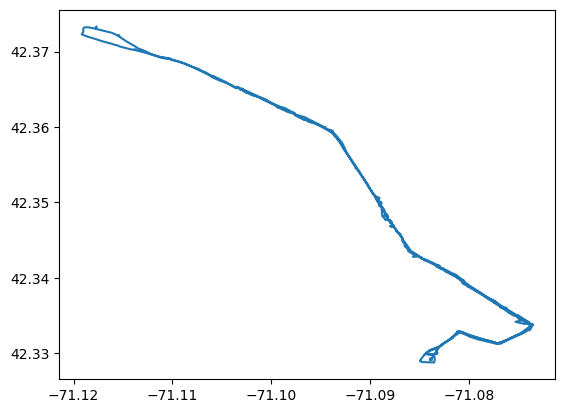

In [5]:
import matplotlib.pyplot as plt

# Establish a connection to the database
cnx = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="MyNewPass",
    port=3306,
    database="MBTAdb"
)
cursor = cnx.cursor()

# Execute the SQL query
sql_query = """
SELECT id, latitude, longitude, updated_at FROM MBTAdb.mbta_buses WHERE id='y1911' ORDER BY updated_at;
"""
cursor.execute(sql_query)

# Fetch the results
results = cursor.fetchall()

# Process the results
# bus_route = {id:[[lat],[long]]}

latitude = []
longitude = []

for row in results:
    latitude.append(row[1])
    longitude.append(row[2])

    
# print(bus_route['y1820'][1][0])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'purple']


plt.plot(longitude, latitude)
   
    
#display the plot    
plt.show()


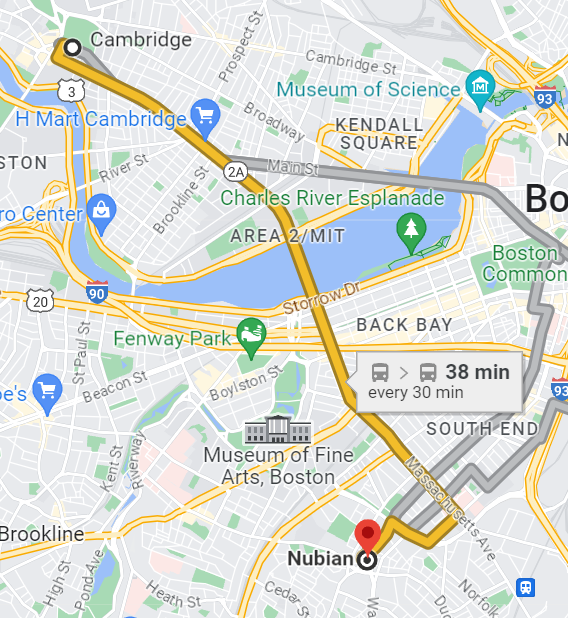

The route's shape matches up with the route as displayed on Google Maps.


### Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [6]:
from haversine import haversine
from datetime import datetime, timedelta

# Establish a connection to the database
cnx = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="MyNewPass",
    port=3306,
    database="MBTAdb"
)
cursor = cnx.cursor()

# Execute the SQL query
sql_query = """
SELECT id, latitude, longitude, current_stop_sequence, updated_at 
FROM MBTAdb.mbta_buses 
WHERE id = 'y1828' AND current_stop_sequence = 1 
OR id = 'y1828' AND current_stop_sequence = 24 
ORDER BY id, updated_at;
"""
cursor.execute(sql_query)

# Fetch the results
results = cursor.fetchall()

# Process the results
latitude = []
longitude = []
curr_stop = []
time = []

for row in results:
    latitude.append(row[1])
    longitude.append(row[2])
    curr_stop.append(row[3])
    time.append(row[4])
#     print(row)

#find lat and long at stop sequence 1, collect timestamp
lat_1 = latitude[5]
long_1 = longitude[5]
time_1 = time[5]
stop_1 = (lat_1, long_1)

#find lat and long at last stop sequence, collect timestamp
lat_24 = latitude[6]
long_24 = longitude[6]
time_24 = time[6]
stop_24 = (lat_24, long_24)

#Use haversine library to calculate distance between points
distance = haversine(stop_1, stop_24, unit='mi')
print(f'The distance between the bus\'s location at stop sequence 1 and stop stop sequence 24 is: ' + str(round(distance,2)) + ' miles')

#timestamp difference
time_diff = (time_24 - time_1)
print(f'The time it took the bus to get from stop sequence 1 to stop sequence 24 is: ' + str(time_diff))

#divide distance/time to estimate speed
#convert to hours
time_in_hrs = (48/60) + (25/3600)
# calc_speed = distance/time
speed = round(distance/time_in_hrs, 2)

print(f'The estimated average speed of the bus from stop sequence 1 to stop sequence 24 is: ' + str(speed) + ' miles per hour')

The distance between the bus's location at stop sequence 1 and stop stop sequence 24 is: 3.46 miles
The time it took the bus to get from stop sequence 1 to stop sequence 24 is: 0:48:25
The estimated average speed of the bus from stop sequence 1 to stop sequence 24 is: 4.28 miles per hour
